### Facsimile inversion 

In [1]:
import numpy as np
import itertools as it
# from Comm.utils import iterative_solve_eta as itsol
import sys
import time

sys.path.append('../Comm/')
import utils as utils

from utils import iterative_solve_eta as itsol
from utils import linear_solve_eta as utils_lin_sol_eta

import importlib
importlib.reload(utils)

import matplotlib.pyplot as plt
from scipy.special import softmax

torch_available = False
try :
    import torch as torch
    dtype = torch.double
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print('Device: GPU')
    else:
        device = torch.device("cpu")
        print('Device: CPU')
    torch_available = True
    print('Pytorch available')
except ImportError:
    print('Pytorch not available')

petsc4py_available = False
try :
    import petsc4py
    petsc4py.init()
    from petsc4py import PETSc
    petsc4py_available = True
    print('Petsc4py available')
except ImportError:
    print('Petsc4py not available')

scipy_sparse_available = False
try :
    import scipy.sparse as sparse
    scipy_sparse_available = True
    print('Scipy sparse available')
except ImportError:
    print('Scipy sparse not available')

cupy_scipy_available = False
try : 
    import cupy as cp
    import cupyx.scipy.sparse as cusparse
    import cupyx.scipy.sparse.linalg
    cupy_scipy_available = True
    print('Cupy sparse available')
except ImportError:
    print('Cupy sparse not available')

Device: GPU
Pytorch available
Petsc4py available
Scipy sparse available
Cupy sparse available


### Tip
To make available the module petsc4py in the Ullyses cluster do the following:
```
module load gnu8 openmpi3 openblas scalapack cuda/11.8 phdf5 python3/3.8
pip install --user Cython==0.29.32
pip install --user mpi4py
export PETSC_CONFIGURE_OPTIONS=' --with-cuda=1 --with-debugging=0'
pip install --user petsc # this will take a while
pip install --user petsc4py
```

### Main problem 
Solve the following:
$$
\begin{align*}
(\mathbf{1} - \gamma \mathbf{T})  \eta &=  \rho
\end{align*}
$$
### Variables
$$
\begin{align*}
\text{pi} &\to \pi(a\ m'\ |\ m\ y)\\
\text{PObs\char`_lim} &\to f(y\ |\ m\ s)\\
\text{gamma} &\to \gamma \to \text{Discount factor}\\
\text{rho0} &\to \rho \to \text{Distribution of the initial position of the agent}\\
\text{Lx, Ly, Lx0, Ly0} &\to \text{Environment setting}\\
\text{find\char`_range} &\to \text{Radius threshold for reach the price}
\end{align*}
$$

## Utilities functions

In [2]:
clip = lambda x, l, u: l if x < l else u if x > u else x

def index_six_to_two(index,M,Ly,Lx):
    # Convert the index of an array of 6 dim to 2 dim
    # new_index_x = index[0] * Lx * Ly + index[1] * Lx + index[2]
    # new_index_y = index[3] * Lx * Ly + index[4] * Lx + index[5]

    # return (new_index_x,new_index_y)
    return (index[0] * Lx * Ly + index[1] * Lx + index[2], 
            index[3] * Lx * Ly + index[4] * Lx + index[5])

def index_six_to_two_2(index,M,Ly,Lx):
    # Convert the index of an array of 6 dim to 2 dim
    # new_index_x = index[0] * Lx * Ly + index[1] * Lx + index[2]
    # new_index_y = index[3] * Lx * Ly + index[4] * Lx + index[5]

    # return (new_index_x,new_index_y)
    return [index[0] * Lx * Ly + index[1] * Lx + index[2], 
            index[3] * Lx * Ly + index[4] * Lx + index[5]]

def solution_test(eta,T,rho,gamma,plot=False):
    sol = (np.eye(T.shape[0]) - gamma * T) @ eta
    if plot:
        # title of the plot rho - (1 - gamma * T) @ eta put in latex style
        plt.title(r'$\mathbf{\rho} - (\mathbf{1} - \gamma \mathbf{T}) \mathbf{\eta} = 0 $')
        plt.plot(sol-rho)
        plt.show()
    return np.allclose(sol,rho)
    

## Set of actions

In [3]:
class AgentActions():
    def __init__(self,actions_number):
        space_dim = 2
        self.A = actions_number
        self.actions = np.zeros((actions_number,space_dim),dtype=int)
        self.actions_names = {}
    
    def set_action(self,action_index : int, action : np.ndarray, action_name : str ):
        self.actions[action_index] = action
        self.actions_names[action_index] = action_name

    def action_move(self,action_index : int):
        if action_index >= self.A:
            print('Error: action not recognized')
            return np.array([0, 0])
        return self.actions[action_index]


## Build Tsm_sm matrix

In [4]:
def build_Tsm_sm_dense(M,Lx,Ly,Lx0,Ly0,find_range,action_size,p_a_mu_m_xy):
    # Action Order
    # left, right, up, down
    
    # tuples to be populated
    #      T indices : "left / right / up / down"
    #      (m', y', x', m, y, x)
    #      pi indices : "left_act / ... "
    #      (m', a, m, y, x)

    # Create the matrix
    Tsm_sm = np.zeros( (M, Ly, Lx, M, Ly, Lx) )

    # Fill the matrix
    for im_new in range(M):
        
        left = [ (im_new,clip(iy-0, 0, Ly-1), clip(ix-1, 0, Lx-1), im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        left_act = [ (0, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        
        for l, la in zip(left, left_act):
            Tsm_sm[l] += p_a_mu_m_xy[la]
        
        right = [ (im_new, iy, clip(ix+1, 0, Lx-1), im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        right_act = [ (1, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for r, ra in zip(right, right_act):
            Tsm_sm[r] += p_a_mu_m_xy[ra]
    
        up = [ (im_new, clip(iy+1, 0, Ly-1), ix,  im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        up_act = [ (2, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for u, ua in zip(up, up_act):
            Tsm_sm[u] += p_a_mu_m_xy[ua]
        
        down = [ (im_new, clip(iy-1, 0, Ly-1), ix, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        down_act = [ (3, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for d, da in zip(down, down_act):
            Tsm_sm[d] += p_a_mu_m_xy[da]
    
    # Delete the rows and columns that have been set to zero depending on the distance to the initial position
    yxs = it.product(np.arange(Ly), np.arange(Lx))
    yx_founds = it.filterfalse(lambda x: (x[0]-Ly0)**2 + (x[1]-Lx0)**2 > find_range**2, yxs)
    
    for yx_found in yx_founds:
        # all transitions starting from the source do not go anywhere
        Tsm_sm[:,yx_found[0],yx_found[1],:,:,:] = 0
        # all transitions ending in the source stop the episode
        Tsm_sm[:,:,:,:,yx_found[0],yx_found[1]] = 0
    
    Tsm_sm_matrix = np.reshape(Tsm_sm, (M*Ly*Lx, M*Ly*Lx))

    return Tsm_sm_matrix

def build_Tsm_sm_sparse(M,Lx,Ly,Lx0,Ly0,find_range,action_size,p_a_mu_m_xy):

    # Create the sparse matrix
    Tsm_sm_sp = sparse.lil_matrix((M*Ly*Lx, M*Ly*Lx), dtype=np.double)

    left_move  = [1,-1]
    # right_move =  0 #  1
    # up_move    =  0 #  1
    # down_move  =  0 # -1

    right_move =  1 #  1
    up_move    =  1 #  1
    down_move  =  -1 # -1
    # Fill the sparse matrix
    for im_new in range(M):
        
        left = [ (im_new, clip(iy+left_move[0],0,Ly-1), clip(ix+left_move[1], 0, Lx-1), im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        left_act = [ (0, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        
        for t, a in zip(left, left_act):
            indexes = index_six_to_two(t,M,Ly,Lx)
            Tsm_sm_sp[indexes] +=  p_a_mu_m_xy[a]
            # if Tsm_sm_sp[indexes] == None :
            #     Tsm_sm_sp[indexes] =  p_a_mu_m_xy[a]
            # else:
            #     Tsm_sm_sp[indexes] +=  p_a_mu_m_xy[a]
                
        right = [ (im_new, iy, clip(ix+right_move, 0, Lx-1), im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        right_act = [ (1, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]

        if right_move != 0:
            for t, a in zip(right, right_act):
                indexes = index_six_to_two(t,M,Ly,Lx)
                Tsm_sm_sp[indexes] +=  p_a_mu_m_xy[a]
                # if Tsm_sm_sp[indexes] == None :
                #     Tsm_sm_sp[indexes] =  p_a_mu_m_xy[a]
                # else:
                #     Tsm_sm_sp[indexes] +=  p_a_mu_m_xy[a]

        up = [ (im_new, clip(iy+up_move, 0, Ly-1), ix,  im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        up_act = [ (2, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]

        if up_move != 0:
            for t, a in zip(up, up_act):
                indexes = index_six_to_two(t,M,Ly,Lx)
                Tsm_sm_sp[indexes] +=  p_a_mu_m_xy[a]
                # if Tsm_sm_sp[indexes] == None :
                #     Tsm_sm_sp[indexes] =  p_a_mu_m_xy[a]
                # else:
                #     Tsm_sm_sp[indexes] +=  p_a_mu_m_xy[a]
        
        down = [ (im_new, clip(iy+down_move, 0, Ly-1), ix, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        down_act = [ (3, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]

        if down_move != 0:
            for t, a in zip(down, down_act):
                indexes = index_six_to_two(t,M,Ly,Lx)
                Tsm_sm_sp[indexes] +=  p_a_mu_m_xy[a]
                # if Tsm_sm_sp[indexes] == None :
                #     Tsm_sm_sp[indexes] =  p_a_mu_m_xy[a]
                # else:
                #     Tsm_sm_sp[indexes] +=  p_a_mu_m_xy[a]

    # Delete the rows and columns that have been set to zero depending on the distance to the initial position
    yxs = it.product(np.arange(Ly), np.arange(Lx))
    yx_founds = it.filterfalse(lambda x: (x[0]-Ly0)**2 + (x[1]-Lx0)**2 > find_range**2, yxs)

    for yx_found in yx_founds:
        for im in range(M):
            # rows to set zero
            indexes = np.zeros(6,dtype=int)
            indexes[0] = indexes[3] = im
            indexes[1] = indexes[4] = yx_found[0]
            indexes[2] = indexes[5] = yx_found[1]
            indexes = index_six_to_two(indexes,M,Ly,Lx)
            # rows to set zero
            Tsm_sm_sp[indexes[0],:] = 0
            # columns to set zero
            Tsm_sm_sp[:,indexes[1]] = 0

    return Tsm_sm_sp

def build_Tsm_sm_sparse_2(M,Lx,Ly,Lx0,Ly0,find_range,action_size,p_a_mu_m_xy,act_hdl,verbose=0):

    if verbose >= 1:
        print("--- build_Tsm_sm_sparse_2 ---")
        print("M:",M,"Lx:",Lx,"Ly:",Ly,"Lx0:",Lx0,"Ly0:",Ly0)

    # Collector of the information of the full matrix
    full_policy_act = np.array([],dtype=np.double)
    full_index_matrix = np.array([],dtype=int)

    for im_new in range(M):
        for act in range(act_hdl.A):

            move = act_hdl.action_move(act)

            limits_x = [0,Lx]
            limits_y = [0,Ly]
            skid_x = 0
            skid_y = 0

            data2clip_range_x = [] #range(Lx)
            target2clipped_x  = [] #range(Lx)
            data2clip_range_y = [] #range(Ly)
            target2clipped_y  = [] #range(Ly)

            # move in x
            if move[-1] > 0: # right
                limits_x[0] += move[-1]
                skid_x -= move[-1]
                data2clip_range_x = [i for i in range(Lx+skid_x,Lx)]
                target2clipped_x = [Lx - 1 for _ in range(abs(move[-1]))]
            elif move[-1] < 0: # left
                limits_x[1] += move[-1]
                skid_x -= move[-1]
                data2clip_range_x = [i for i in range(skid_x)]
                target2clipped_x = [0 for _ in range(abs(move[-1]))]

            # move in y
            if move[-2] > 0: # up
                limits_y[0] += move[-2]
                skid_y -= move[-2]
                data2clip_range_y = [i for i in range(Ly+skid_y,Ly)]
                target2clipped_y = [Ly - 1 for _ in range(abs(move[-2]))]
            elif move[-2] < 0: # down
                limits_y[1] += move[-2]
                skid_y -= move[-2]
                data2clip_range_y = [i for i in range(skid_y)]
                target2clipped_y = [0 for _ in range(abs(move[-2]))]
            
            # move in z

            # Number of move directions
            move_dir = []
            if move[-1] != 0:
                move_dir.append(0)
            if move[-2] != 0:
                move_dir.append(1)
            # if move[-3] != 0:
            #     move_dir.append(2)

            if verbose >= 1:
                print("-"*50)
                print("act {:>5}".format(act_hdl.actions_names[act]),"limits y:",limits_y,"x:",limits_x,"move",move,"skid",skid_y,skid_x,"\nclipped",data2clip_range_y,data2clip_range_x,"\nntarget",target2clipped_y,target2clipped_x)

            #-----------------------------------------------------------------
            # Fill the direct values
            #-----------------------------------------------------------------
            # index_policy_act = [ (act, im_new, im, iy+skid_y, ix+skid_x)  
            #                      for im in range(M)  
            #                         for iy in range(limits_y[0],limits_y[1])
            #                             for ix in range(limits_x[0],limits_x[1]) 
            #                             ]
            full_policy_act = np.concatenate(
               (full_policy_act,
                np.array([ p_a_mu_m_xy[act, im_new, im, iy+skid_y, ix+skid_x]  
                                for im in range(M)  
                                    for iy in range(limits_y[0],limits_y[1])
                                        for ix in range(limits_x[0],limits_x[1]) 
                                        ]
                        )
                )
            )
            # index_matrix_act = [ index_six_to_two((im_new, iy, ix, im, iy+skid_y, ix+skid_x),M,Ly,Lx)
            #                      for im in range(M) 
            #                         for iy in range(limits_y[0],limits_y[1])
            #                             for ix in range(limits_x[0],limits_x[1]) 
            #                             ]
            full_index_matrix = np.concatenate(
                (full_index_matrix,
                 np.array([ index_six_to_two_2((im_new, iy, ix, im, iy+skid_y, ix+skid_x),M,Ly,Lx)
                                 for im in range(M) 
                                    for iy in range(limits_y[0],limits_y[1])
                                        for ix in range(limits_x[0],limits_x[1]) 
                                        ]
                        )
                )
            ,axis=None)

            if verbose >= 1:
                for i in range(5):
                    print("index_policy_act",index_policy_act[i],"index_matrix_act",index_matrix_act[i])
                # Test if the list is sorted by the fisrt element of the tuple
                def is_sorted_by_first_element(lst):
                    return all(lst[i][0] <= lst[i+1][0] for i in range(len(lst)-1))

                print("is_sorted_by_first_element",is_sorted_by_first_element(index_policy_act))


            # index_matrix_act = [ index_six_to_two(index,M,Ly,Lx) for index in index_matrix_act]

            # for t, a in zip(index_matrix_act, index_policy_act):
            #     Tsm_sm_sp[t] += p_a_mu_m_xy[a]

            #-----------------------------------------------------------------
            # Add the clipped values 
            #-----------------------------------------------------------------
            if verbose >= 1:
                print("move_dir",move_dir)
            
            limits_x = [0,Lx] # list of consecutive actions to clip

            for m_dir in move_dir:
                # clip in x
                if m_dir == 0:
                    range_x = data2clip_range_x
                    range_y = range(Ly)
                    target_x = target2clipped_x
                    target_y = [clip(i,0,Ly-1) for i in range(0-skid_y,Ly-skid_y)]

                    if range_x[0] == 0:
                        limits_x[0] = len(target_x)
                        limits_x[1] = Lx
                    else:   
                        limits_x[0] = 0
                        limits_x[1] = Lx - len(target_x) 

                # clip in y
                elif m_dir == 1:
                    range_x = range(limits_x[0],limits_x[1])
                    range_y = data2clip_range_y
                    target_x = [clip(i,0,Lx-1) for i in range(limits_x[0]-skid_x,limits_x[1]-skid_x)]
                    target_y = target2clipped_y 

                if verbose >= 1:
                    print("m_dir",m_dir,"range_x",range_x,"range_y",range_y,"target_x",target_x,"target_y",target_y)
                    print("limits_x",limits_x)
                

                # index_policy_act = [ (act, im_new, im, iy, ix)  
                #                     for im in range(M)  
                #                         for iy in range_y
                #                             for ix in range_x 
                #                             ]
                full_policy_act = np.concatenate(
                    (full_policy_act,
                    np.array([ p_a_mu_m_xy[act, im_new, im, iy, ix]  
                                    for im in range(M)  
                                        for iy in range_y
                                            for ix in range_x
                                            ]
                            )
                    )
                )

                # index_matrix_act = [ index_six_to_two((im_new, iy_clip, ix_clip, im, iy, ix),M,Ly,Lx)
                #                     for im in range(M) 
                #                         for iy_clip, iy in zip(target_y,range_y)
                #                             for ix_clip, ix in zip(target_x,range_x)
                #                             ]

                full_index_matrix = np.concatenate(
                    (full_index_matrix,
                     np.array([ index_six_to_two_2((im_new, iy_clip, ix_clip, im, iy, ix),M,Ly,Lx)
                                     for im in range(M) 
                                        for iy_clip, iy in zip(target_y,range_y)
                                            for ix_clip, ix in zip(target_x,range_x)
                                            ]
                            )
                    )
                ,axis=None)


                if verbose >= 2:
                    print("policy_act size:",len(index_policy_act),"matrix size:",len(index_matrix_act))
                    for i in range(min(Ly+20000,len(index_policy_act))):
                        print("index_policy_act",index_policy_act[i],"index_matrix_act",index_matrix_act[i])

                # index_matrix_act = [ index_six_to_two(index,M,Ly,Lx) for index in index_matrix_act]

                # for t, a in zip(index_matrix_act, index_policy_act):
                #     Tsm_sm_sp[t] += p_a_mu_m_xy[a]

        # End for act
    # End for im_new

    # Create the sparse matrix
    # Tsm_sm_sp = sparse.lil_matrix((M*Ly*Lx, M*Ly*Lx), dtype=np.double)

    entries = full_policy_act.shape[0]
    full_index_matrix = full_index_matrix.reshape(entries,2)


    if verbose >= 1:
        print("full_policy_act size:",len(full_policy_act),"full_index_matrix size:",len(full_index_matrix))
        print("full_policy_act",full_policy_act.shape,"full_index_matrix",full_index_matrix.shape)
    Tsm_sm_sp = sparse.coo_matrix((full_policy_act, (full_index_matrix[:,0], full_index_matrix[:,1])), shape=(M*Ly*Lx, M*Ly*Lx), dtype=np.double).tolil()   
    

    # Delete the rows and columns that have been set to zero depending on the distance to the initial position
    yxs = it.product(np.arange(Ly), np.arange(Lx))
    yx_founds = it.filterfalse(lambda x: (x[0]-Ly0)**2 + (x[1]-Lx0)**2 > find_range**2, yxs)

    indexes = np.zeros(6,dtype=int)
    for yx_found in yx_founds:
        for im in range(M):
            indexes[0] = indexes[3] = im
            indexes[1] = indexes[4] = yx_found[0]
            indexes[2] = indexes[5] = yx_found[1]
            indexes_mat = index_six_to_two(indexes,M,Ly,Lx)
            # rows to set zero
            Tsm_sm_sp[indexes_mat[0],:] = 0
            # columns to set zero
            Tsm_sm_sp[:,indexes_mat[1]] = 0

    return Tsm_sm_sp

In [5]:
test_Tmatrix_building = False

if test_Tmatrix_building:
    def plot_matrix(T,map_1,map_2):

        if sparse.issparse(T):
            T = T.toarray()
        print("T shape",T.shape)
        T_map_full = np.reshape(T,(M,y,x,M,y,x))

        T_map_1 = T_map_full[0,map_1[0],map_1[1],0,map_1[2],map_1[3]]
        T_map_2 = T_map_full[0,map_2[0],map_2[1],0,map_2[2],map_2[3]]

        print_number = False
        if T_map_full.shape[-1] < 10:
            print_number = True

        fig, ax = plt.subplots(1,2)
        if print_number:
            for (j,i),label in np.ndenumerate(T_map_1):
                ax[0].text(i,j,label,ha='center',va='center')
        ax[0].imshow(T_map_1)
        ax[0].set_title("T_map_1")

        if print_number:
            for (j,i),label in np.ndenumerate(T_map_2):
                ax[1].text(i,j,label,ha='center',va='center')
        ax[1].imshow(T_map_2)
        ax[1].set_title("T_map_2")

        plt.show()

    scale_factor = 1
    M = 2
    x = 5 * scale_factor
    y = 8 * scale_factor

    act_hdl = AgentActions(4)
    act_hdl.set_action(0, np.array([  1, -1]), 'left')
    act_hdl.set_action(1, np.array([  0,  1]), 'right')
    act_hdl.set_action(2, np.array([ -1,  0]), 'down')
    act_hdl.set_action(3, np.array([  1,  0]), 'up')

    p_tmp = np.arange(stop=x*y+1,start=1).reshape(y,x)
    p_tmp = np.repeat(p_tmp[np.newaxis,:,:],M,axis=0)
    p_tmp = np.repeat(p_tmp[np.newaxis,:,:,:],M,axis=0)
    p_tmp = np.repeat(p_tmp[np.newaxis,:,:,:,:],act_hdl.A,axis=0)

    print("p_tmp shape",p_tmp.shape)

    # T = build_Tsm_sm_dense(M,x,y,3,2,1.1,act_hdl.A,p_tmp)
    time_start = time.time()
    T = build_Tsm_sm_sparse(M,x,y,7,4,1.1,act_hdl.A,p_tmp)
    time_step = time.time()
    T_sp = build_Tsm_sm_sparse_2(M,x,y,7,4,1.1,4,p_tmp,act_hdl)
    time_end = time.time()

    print("time to build Tsm_sm_sparse:",time_step-time_start)
    print("time to build Tsm_sm_sparse_2:",time_end-time_step)

    All = slice(None)
    view_x = 2
    view_y = 2
    map_1 = [All,All,view_y,view_x]
    map_2 = [view_y,view_x,All,All]

    plot_matrix(T,map_1,map_2)

    plot_matrix(T_sp,map_1,map_2)
    T = T.toarray()
    T_sp = T_sp.toarray()
    print("Tsm_sm_matrix == Tsm_sm_matrix_2:",np.allclose(T_sp,T))
    print("norm L2",np.linalg.norm(T_sp-T))


    plt.imshow(T_sp-T)
    plt.colorbar()
    plt.show()

    T = build_Tsm_sm_sparse_2(M,x,y,7,4,1.1,4,p_tmp,act_hdl,verbose=0)



## Functions to the $\eta$ with different libraries

In [50]:
def eta_petsc(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0,ks_type='bcgs',ps_type='jacobi'):
    """
    Solve linear system for eta using PETSc
    """

    # Get the size of the matrix
    mat_size = M*Ly*Lx
    action_size = 4
    # Get the maximum number of non zeros values per row for Tsm_sm
    count_non_zeros_in_row = np.ones(mat_size,dtype=np.int32) * action_size * M
    count_non_zeros_in_row[0] -= M
    count_non_zeros_in_row[-1] -= M

    # print('Number of non-zero elements per row: ', count_non_zeros_in_row)

    # Create PETSc matrix
    A = PETSc.Mat()
    A.createAIJ([M*Lx*Ly,M*Lx*Ly], nnz=count_non_zeros_in_row)

    # Fill PETSc matrix
    # non_zeros_Tsm = np.transpose(np.nonzero(Tsm_sm_matrix))
    # for index in non_zeros_Tsm:
    #     A.setValues(index[0],index[1],Tsm_sm_matrix[index[0],index[1]])

    # Tsm_sm_matrix = Tsm_sm_matrix.tocsr()
    # A.setValuesCSR(Tsm_sm_matrix.indptr,Tsm_sm_matrix.indices,Tsm_sm_matrix.data)
    
    # -----------------------------
    """
    Tsm_sm_matrix = Tsm_sm_matrix.tocsr()
    
    rstart, rend = A.getOwnershipRange()

    indptr = Tsm_sm_matrix.indptr[rstart:rend+1]-Tsm_sm_matrix.indptr[rstart]
    indices_slice = np.s_[Tsm_sm_matrix.indptr[rstart]:Tsm_sm_matrix.indptr[rend]]

    A.setValuesCSR(indptr, Tsm_sm_matrix.indices[indices_slice], Tsm_sm_matrix.data[indices_slice])
    """
    # -----------------------------
    Tsm_sm_matrix = Tsm_sm_matrix.tocoo()
    # create a list of tuples (row, col, value)
    values = list(zip(Tsm_sm_matrix.row, Tsm_sm_matrix.col, Tsm_sm_matrix.data))
    # sort the list by row
    values.sort(key=lambda x: x[0])
    rstart, rend = A.getOwnershipRange()
    # filter the values to keep only the ones in the ownership range
    values = [x for x in values if x[0] >= rstart and x[0] < rend]
    # get the repeated row indices
    

    



    A.assemblyBegin()
    A.assemblyEnd()

    # eye matrix with PETSc
    ones = PETSc.Mat()
    ones.createAIJ(size=(M*Lx*Ly,M*Lx*Ly), nnz=1)
    for i in range(M*Lx*Ly):
        ones.setValues(i,i,1.0)

    ones.assemblyBegin()
    ones.assemblyEnd()

    # matrix_A =  I - gamma * T
    A.aypx(-gamma,ones)

    # print('Matrix A assembled', A.size)
    # print(A.getInfo())
    
    x, b =  A.createVecs()
    b.setValues(np.arange(rho0.shape[0],dtype=np.int32),rho0)
    b.assemble()

    # Start the solver
    ksp = PETSc.KSP().create()
    ksp.setOperators(A)
    ksp.setType(ks_type)
    ksp.getPC().setType(ps_type)
    ksp.setTolerances(rtol=1e-10)

    ksp.setUp()
    ksp.solve(b, x)

    ksp.destroy()
    A.destroy()
    ones.destroy()
    b.destroy()

    eta = x.getArray()
    x.destroy()

    return eta

In [31]:

def eta_numpy(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0):
    """
    Invert a matrix using numpy
    """
    to_invert = np.eye(M*Ly*Lx) - gamma * Tsm_sm_matrix
    inverted = np.linalg.inv(to_invert)
    new_eta = inverted @ rho0

    return new_eta

def eta_numpy_sol(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0):
    """
    Solve linear system
    """
    mat_A = np.eye(M*Ly*Lx) - gamma * Tsm_sm_matrix
    new_eta = np.linalg.solve(mat_A,rho0)

    return new_eta

def eta_torch(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0):
    """
    Invert a matrix using torch
    """
    Tsm_sm_matrix_torch = torch.from_numpy(Tsm_sm_matrix).type(dtype).to(device)

    rho0_torch = torch.from_numpy(rho0).type(dtype).to(device) 

    to_invert = torch.eye(M*Ly*Lx,dtype=dtype,device=device) - gamma * Tsm_sm_matrix_torch
    inverted = torch.torch.linalg.inv(to_invert)
    new_eta = inverted @ rho0_torch

    new_eta = new_eta.cpu().numpy()

    return new_eta

def eta_torch_sol(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0):
    """
    Solve linear system using torch
    """
    Tsm_sm_matrix_torch = torch.from_numpy(Tsm_sm_matrix).type(dtype).to(device)

    rho0_torch = torch.from_numpy(rho0).type(dtype).to(device) 

    A_mat = torch.eye(M*Ly*Lx,dtype=dtype,device=device) - gamma * Tsm_sm_matrix_torch
    new_eta = torch.linalg.solve(A_mat,rho0_torch)

    new_eta = new_eta.cpu().numpy()

    return new_eta

def eta_scipy_sparse_solve(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0):
    """
    Solve linear system using scipy sparce
    """
    Tsm_sm_matrix_sparce = sparse.csr_matrix(Tsm_sm_matrix)
    to_invert = sparse.eye(M*Ly*Lx) - gamma * Tsm_sm_matrix_sparce
    new_eta = sparse.linalg.spsolve(to_invert,rho0)

    return new_eta

def eta_cupy_sparse_solve(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0):
    """
    Solve linear system using cupy sparse
    """
    Tsm_sm_matrix_cupy = cusparse.csr_matrix(Tsm_sm_matrix)
    to_invert = cusparse.eye(M*Ly*Lx) - gamma * Tsm_sm_matrix_cupy
    rho0_cupy = cp.asarray(rho0)
    new_eta_cupy = cusparse.linalg.spsolve(to_invert,rho0_cupy)
    new_eta = cp.asnumpy(new_eta_cupy)

    return new_eta


## Solve the problem

In [8]:

def solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range, act_hdl,func_eta=eta_numpy, verbose=False):
    """
    This function should solve the following:
    --> New_eta = (1 - gamma T)^-1 rho
    """
    # O = Observations
    # M = Memory
    # A = Actions
    O, M, A = pi.shape
    # L = Dimension of the environment
    L = Lx * Ly
    new_eta = np.zeros(M*L)
    
    # PY has size ~ 10^5
    PY = PObs_lim.reshape(O, M, Ly, Lx)
    # PY has size ~ 10^2
    PAMU = pi.reshape(O, M, M, A//M)
    
    p_a_mu_m_xy = np.einsum( 'omyx, omna -> anmyx', PY, PAMU)
    # T [ s'm'  sm] = sum_a, mu p(s'm' | sm a mu) p(a mu | sm)
    #               = sum_a, mu p(s'm' | sm a mu) sum_y f(y | s) pi(a mu | y m)
    
    need_sparse = False
    if func_eta == eta_scipy_sparce_solve or func_eta == eta_petsc or func_eta == eta_cupy_sparse_solve:
        need_sparse = True
    # Tsm_sm has size ~ 10^5 x 10^5 or more
    if need_sparse:
        time_start = time.time()
        # Tsm_sm_matrix = build_Tsm_sm_sparse(M,Lx,Ly,Lx0,Ly0,find_range,A//M,p_a_mu_m_xy)
        Tsm_sm_matrix = build_Tsm_sm_sparse_2(M,Lx,Ly,Lx0,Ly0,find_range,A//M,p_a_mu_m_xy,act_hdl)
        time_end = time.time()

    else:
        Tsm_sm_matrix = build_Tsm_sm_dense(M,Lx,Ly,Lx0,Ly0,find_range,A//M,p_a_mu_m_xy)

    if verbose:
        print("pi shape:",pi.shape)
        print("new_eta shape:",new_eta.shape)
        print("PY shape:",PY.shape, "PAMU shape:",PAMU.shape)
        print("p_a_mu_m_xy shape:",p_a_mu_m_xy.shape)

        if need_sparse:
            print("               Type of Tsm_sm_matrix:",type(Tsm_sm_matrix))
            print("number of non-zeros in Tsm_sm_matrix:",Tsm_sm_matrix.nnz)
            print("number of     zeros in Tsm_sm_matrix:",M*Lx*Ly*M*Lx*Ly - Tsm_sm_matrix.nnz)
            print("               opacity of the matrix: {:7.4f}".format(Tsm_sm_matrix.nnz/(M*Lx*Ly*M*Lx*Ly) * 100.0), "%")
            print("            time to build the matrix: {:7.4f}".format(time_end - time_start), "s")
            plt.imshow(Tsm_sm_matrix.toarray())
            plt.show()

        else :
            print("number of non-zeros in Tsm_sm_matrix:",np.count_nonzero(Tsm_sm_matrix != 0))
            print("number of     zeros in Tsm_sm_matrix:",np.count_nonzero(Tsm_sm_matrix == 0))
            print("               opacity of the matrix: {:7.4f}".format(np.count_nonzero(Tsm_sm_matrix != 0)/Tsm_sm_matrix.size * 100.0), "%") 
            plt.imshow(Tsm_sm_matrix)
            plt.show()

    new_eta = func_eta(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0)
    
    return new_eta, Tsm_sm_matrix

## TEST

Solving with linear algebra
pi shape: (2, 2, 8)
new_eta shape: (256,)
PY shape: (2, 2, 16, 8) PAMU shape: (2, 2, 2, 4)
p_a_mu_m_xy shape: (4, 2, 2, 16, 8)
               Type of Tsm_sm_matrix: <class 'scipy.sparse._lil.lil_matrix'>
number of non-zeros in Tsm_sm_matrix: 1904
number of     zeros in Tsm_sm_matrix: 63632
               opacity of the matrix:  2.9053 %
            time to build the matrix:  0.0259 s


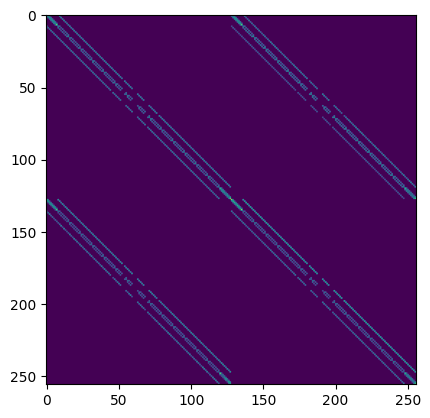

Solving with iterative solver


In [51]:
M = 2 # O(10) 
O = 2 # 2/3
dim_factor = 2
Lx = 4 * dim_factor # O(100)-O(1000)
# Lx = 27
Ly = 8 * dim_factor # O(100)-O(1000)        
# Ly = 39
a_size = 4

Lx0 = 5
# Lx0 = 13
Ly0 = 7
# Ly0 = 27

# Create an action handler
act_hdl = AgentActions(a_size)
act_hdl.set_action(0, np.array([0,-1]), 'left')
act_hdl.set_action(1, np.array([0,1]), 'right')
act_hdl.set_action(2, np.array([1,0]), 'up')
act_hdl.set_action(3, np.array([-1,0]), 'down')

np.random.seed(33+33)

gamma = 0.99
gamma = 0.99975 

find_range = 1.1
tol = 1e-8

pi = softmax( np.random.rand(O,M,M*a_size), 2)

PObs_lim = np.random.rand(O, M*Lx*Ly)

# PObs_lim = np.ones((O, M*Lx*Ly))

# PObs_lim_map = PObs_lim.reshape((O,M,Ly,Lx))
# PObs_lim_map[0,:,Ly0,Lx0] = 0.0
# PObs_lim_map[0,0,5:Ly0-int(find_range),Lx0-2:Lx0+2] = 0.5
# PObs_lim_map[0,1,5:Ly0-int(find_range),Lx0-2:Lx0+2] = 0.6

# PObs_lim = PObs_lim_map.reshape((O,M*Lx*Ly))

PObs_lim[1] = 1-PObs_lim[0]

rho0 = np.random.rand(M*Lx*Ly)
rho0[Lx:] = 0
rho0 /= np.sum(rho0)

# rho0 = np.zeros(M*Lx*Ly)
# rho0[:Lx] = (1-PObs_lim[0,:Lx])/np.sum((1-PObs_lim[0,:Lx]))

eta0 = np.random.rand(M*Lx*Ly)

print("Solving with linear algebra")
inv_sol, T = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range, act_hdl, verbose=True, func_eta=eta_petsc)
# inv_sol, T = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range, act_hdl, verbose=True, func_eta=eta_scipy_sparse_solve)
# inv_sol, T = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range, act_hdl, verbose=True, func_eta=eta_numpy_sol)
# inv_sol, T = utils_lin_sol_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range, verbose=True)
print("Solving with iterative solver")
iter_sol = itsol(pi, PObs_lim, gamma, rho0, eta0, tol, Lx, Ly, Lx0, Ly0, find_range)


## Comparison of the results

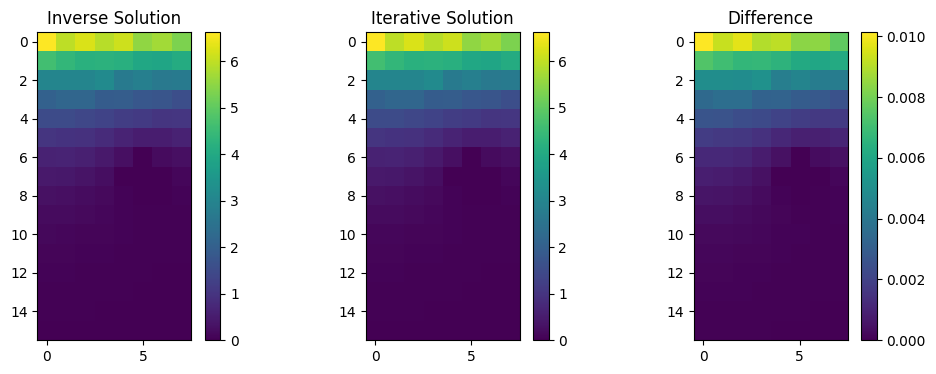

In [34]:
memory = 0

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Inverse Solution")
plt.imshow(inv_sol.reshape(M,Ly,Lx)[memory])
plt.colorbar()
plt.subplot(1,3,2)
plt.title("Iterative Solution")
plt.imshow(iter_sol.reshape(M,Ly,Lx)[memory])
plt.colorbar()
plt.subplot(1,3,3)
plt.title("Difference")
plt.imshow(np.abs(iter_sol.reshape(M,Ly,Lx)[memory]-inv_sol.reshape(M,Ly,Lx)[memory]))
plt.colorbar()
plt.show()



In [ ]:
print("rho0 shape:{}".format(rho0.shape))
rho_map = rho0.reshape((Ly,Lx,M))
plt.figure(figsize=(12,12//M))
for m in range(M):
    plt.subplot(1,M,m+1)
    plt.imshow(rho_map[:,:,m])
    plt.colorbar()


In [ ]:
print("PObs_lim shape:{}, {}".format(PObs_lim.shape,Lx*Ly*M))
PObs_lim_map = PObs_lim.reshape((O,M,Ly,Lx))

for o in range(O):
    plt.figure(figsize=(12,12//M))
    for m in range(M):
        plt.subplot(1,M,m+1)
        plt.title('PObs_lim, o:{}, m:{}'.format(o,m))
        plt.imshow(PObs_lim_map[o,m,:,:])
        plt.colorbar()
    plt.show()

In [ ]:
print("pi shape:{}".format(pi.shape))
print(pi)

## Benchmarking of the solvers

In [ ]:
solvers =      [eta_numpy, eta_numpy_sol, eta_torch, eta_torch_sol, eta_scipy_sparce_solve, eta_cupy_sparse_solve, eta_petsc]
name_solvers = [  "Numpy",   "Numpy Sol",   "Torch",   "Torch Sol",         "Scipy Sparse",         "Cupy Sparse",   "Petsc"]

for solver, name_solver in zip(solvers, name_solvers):
    print("Method: {:>14}".format(name_solver), end=" ")
    %timeit solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,act_hdl,func_eta=solver, verbose=False)
    # solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,func_eta=solver, verbose=True)

print("\nIterative Solution", end=" ")

%timeit itsol(pi, PObs_lim, gamma, rho0, eta0, tol, Lx, Ly, Lx0, Ly0, find_range)

## Profiling

In [ ]:
# Profiler line by line
%load_ext line_profiler
# %lprun?

In [ ]:
for solver, name_solver in zip(solvers, name_solvers):
    print("Method: {:>14}".format(name_solver), end=" ")
    %lprun -f solve_eta solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,act_hdl,func_eta=solver, verbose=False)

# %lprun -f solve_eta solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range)

In [ ]:
%lprun -f itsol  itsol(pi, PObs_lim, gamma, rho0, eta0, tol, Lx, Ly, Lx0, Ly0, find_range)

Test if the solution of the different solvers are correct, using 
$$\mathbf{\rho} - (\mathbf{1} - \gamma \mathbf{T}) \mathbf{\eta} = 0 $$ 

In [ ]:
print("Shape     iter_sol:", iter_sol.shape[0],
          "max: {:.4f} min: {:.4f}".format(np.max(iter_sol), np.min(iter_sol)))

for solver, name_solver in zip(solvers, name_solvers):
    inv_sol, T = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,act_hdl,func_eta=solver)
    print("Shape {:>12}: {:} max: {:.4f} min: {:.4f}".format(name_solver, inv_sol.shape[0], np.max(inv_sol), np.min(inv_sol)), end=" ")  
    print("|| Passing test of solver:",solution_test(inv_sol,T,rho0,gamma), end=" ")
    print("|| Diff from iter_sol: {:.8f}".format(np.sum(np.abs(iter_sol-inv_sol))))
print("-"*50)
print("Diff between solvers")        
for i in range(len(solvers)):
    inv_sol_i, T_i = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,act_hdl,func_eta=solvers[i])
    for j in range(i+1,len(solvers)):
        inv_sol_j, T_j = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,act_hdl,func_eta=solvers[j])
        print("Difference between {:>12} and {:>12}: {:.5e}".format(name_solvers[i], name_solvers[j], np.sum(np.abs(inv_sol_i-inv_sol_j)))) 


Compare the solution of each solver with the iterative solution

In [ ]:

for solver, name_solver in zip(solvers, name_solvers):
    print("Test: {:>12}".format(name_solver))
    inv_sol, T = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,act_hdl,func_eta=solver)
    print("Shape inv_sol:", inv_sol.shape, "max:", np.max(inv_sol), "min:", np.min(inv_sol))
    print("Passing test of solver",solution_test(inv_sol,T,rho0,gamma,plot=True))
    
    fig = plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    plt.title(name_solver)
    plt.imshow(inv_sol.reshape(M,Ly,Lx)[memory])
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.title("Iterative Solution")
    plt.imshow(iter_sol.reshape(M,Ly,Lx)[memory])
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.title("Difference")
    plt.imshow(np.abs(iter_sol.reshape(M,Ly,Lx)[memory]-inv_sol.reshape(M,Ly,Lx)[memory]))
    plt.colorbar()
    plt.show()


Compare all the solutions generated in all permutations 

In [ ]:
    
for i in range(len(solvers)):
    for j in range(i+1,len(solvers)):
        inv_sol_i, T_i = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,act_hdl,func_eta=solvers[i])
        inv_sol_j, T_j = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,act_hdl,func_eta=solvers[j])
        print("Difference between", name_solvers[i], "and", name_solvers[j], np.sum(np.abs(inv_sol_i-inv_sol_j)))

        fig = plt.figure(figsize=(12,6))
        plt.subplot(1,3,1)
        plt.title(name_solvers[i])
        plt.imshow(inv_sol_i.reshape(M,Ly,Lx)[memory])  
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.title(name_solvers[j])
        plt.imshow(inv_sol_j.reshape(M,Ly,Lx)[memory])
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.title("Difference")
        plt.imshow(np.abs(inv_sol_i.reshape(M,Ly,Lx)[memory]-inv_sol_j.reshape(M,Ly,Lx)[memory]))
        plt.colorbar()
        plt.show()
        
